In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kstest, jarque_bera, shapiro, ttest_1samp
from statsmodels.stats.diagnostic import acorr_ljungbox,het_arch, het_white
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import genextreme as gev
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF


import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams['savefig.facecolor']='white'

In [49]:
def normality(data):
    mu = np.mean(data)
    sigma = np.std(data)

    print("Test Kołmogorowa-Smirnowa: {}.".format(kstest((data-mu)/sigma, 'norm').pvalue))
    print("Test Jarque-Bera: {}.".format(jarque_bera(data).pvalue))
    print("Test Shapiro-Wilka: {}.".format(shapiro(data).pvalue))

    fig, axes = plt.subplots(1, 3, figsize=(20,6))

    x = np.arange(min(data), max(data)+1)
    axes[0].hist(data, bins=20, color='deeppink', alpha=0.6, density=True, label="Histogram prawdopodobieństwa danych")
    axes[0].plot(x, stats.norm.pdf(x, mu, sigma), color='indigo', label="Gęstość teoretyczna")
    axes[0].set_title('Porównanie gęstości')
    axes[0].legend(loc="best")

    ecdf = ECDF(data)
    axes[1].set_title('Porównanie dystrybuant')
    axes[1].plot(x, ecdf(x), color='deeppink', label='Dystrybuanta empiryczna')
    axes[1].plot(x, stats.norm.cdf(x, mu, sigma), color="indigo", linestyle='--', label="Dystrybuanta teoretyczna")
    axes[1].legend(loc="best")

    bplot = axes[2].boxplot(data, patch_artist=True, medianprops=dict(color="deeppink"))
    bplot['boxes'][0].set_facecolor('white')
    axes[2].grid(False)
    axes[2].set_title("Boxplot danych")

    plt.show()

# 1. Przygotowanie danych

In [50]:
cocoa = pd.read_csv('Cocoa.csv')
milk = pd.read_csv('Milk.csv')
sugar = pd.read_csv('Sugar.csv')

In [51]:
cocoa['Date'] = pd.to_datetime(cocoa['Date'])
milk['Date'] = pd.to_datetime(milk['Date'])
sugar['Date'] = pd.to_datetime(sugar['Date'])

In [52]:
cocoa['Close/Last'] = cocoa['Close/Last'].astype(float)
milk['Close/Last'] = milk['Close/Last'].astype(float)
sugar['Close/Last'] = sugar['Close/Last'].astype(float)

In [53]:
pln_usd = pd.read_csv("PLNUSD=X.csv")

In [54]:
pln_usd = pln_usd[pln_usd["Close"].notnull()]

In [55]:
pln_usd.reset_index(inplace=True)

In [56]:
pln_usd["Date"] = pd.to_datetime(pln_usd["Date"])

In [57]:
dates = []
for i in range(len(pln_usd)):
    if pln_usd["Date"][i] not in list(cocoa["Date"]):
        dates.append(pln_usd["Date"][i])
    if pln_usd["Date"][i] not in list(milk["Date"]):
        dates.append(pln_usd["Date"][i])
    if pln_usd["Date"][i] not in list(sugar["Date"]):
        dates.append(pln_usd["Date"][i])

In [58]:
for i in range(len(cocoa)):
    if cocoa["Date"][i] not in list(pln_usd["Date"]):
        dates.append(cocoa["Date"][i])
    if sugar["Date"][i] not in list(pln_usd["Date"]):
        dates.append(sugar["Date"][i])

In [59]:
for i in range(len(milk)):
    if milk["Date"][i] not in list(pln_usd["Date"]):
        dates.append(milk["Date"][i])

In [60]:
dates = list(set(dates))

In [61]:
for i in range(len(dates)):
    pln_usd = pln_usd[pln_usd["Date"] !=  dates[i]]
    cocoa = cocoa[cocoa["Date"] !=  dates[i]]
    milk = milk[milk["Date"] !=  dates[i]]
    sugar = sugar[sugar["Date"] !=  dates[i]]

In [62]:
pln_usd = pln_usd[::-1]

In [63]:
pln_usd.reset_index(inplace=True)
cocoa.reset_index(inplace=True)
milk.reset_index(inplace=True)
sugar.reset_index(inplace=True)

Zamiana danych na stopy procentowe.

In [64]:
T = 1/252
cocoa_close = np.array([round((cocoa['Close/Last'][i] - cocoa['Close/Last'][i+1])/(cocoa['Close/Last'][i+1] * T),3) for i in range(len(cocoa)-1)])
milk_close = np.array([round((milk['Close/Last'][i] - milk['Close/Last'][i+1])/(milk['Close/Last'][i+1] * T), 3) for i in range(len(milk)-1)])
sugar_close = np.array([round((sugar['Close/Last'][i] - sugar['Close/Last'][i+1])/(sugar['Close/Last'][i+1] * T), 3) for i in range(len(sugar)-1)])
pln_usd_close = np.array([round((pln_usd['Close'][i] - pln_usd['Close'][i+1])/(pln_usd['Close'][i+1] * T), 3) for i in range(len(pln_usd)-1)])

In [65]:
cocoa_close /= 100
milk_close /= 100
sugar_close /= 100
pln_usd_close /= 100

In [66]:
mu_c = np.mean(cocoa_close)
sigma_c = np.std(cocoa_close)
print(mu_c, sigma_c)

mu_m = np.mean(milk_close)
sigma_m = np.std(milk_close)
print(mu_m, sigma_m)

mu_s = np.mean(sugar_close)
sigma_s = np.std(sugar_close)
print(mu_s, sigma_s)

0.0011226437699680513 0.046895540026747284
0.0017608067092651758 0.06315052203248535
0.0007991214057507985 0.0481337056540928


In [67]:
n = len(cocoa_close)
C = cocoa_close.reshape(1,n)
M = milk_close.reshape(1,n)
S = sugar_close.reshape(1,n)
R = np.concatenate([C,M,S],axis=0)
print(R)

[[-0.03694 -0.00097  0.0127  ... -0.00941  0.0313   0.04996]
 [-0.00205  0.0417  -0.02171 ... -0.00497  0.00166  0.     ]
 [-0.0799   0.03211 -0.01532 ... -0.03277 -0.1246  -0.00931]]


$R_p = 0.4\cdot R_c + 0.22\cdot R_s + 0.38\cdot R_m$

In [68]:
Rp = 0.5 * cocoa_close + 0.2 * milk_close + 0.3 * sugar_close

In [69]:
w = np.array([0.5, 0.2, 0.3])
print("Stopa zwrotu porfela: {}, ryzyko portfela: {}.".format(w[0]*mu_c + w[1]*mu_m + w[2]*mu_s, np.sqrt(np.dot(w.T, np.dot(np.cov(R), w)))))

Stopa zwrotu porfela: 0.0011532196485623003, ryzyko portfela: 0.03151053404357198.


# 2. Wartość zagrożna (dla zmiennej kakao)

## a) metoda parametryczna

In [70]:
L = cocoa_close[cocoa_close > 0] #dodatnie stopy zwrotu są dla nas stratą

In [71]:
cocoa_close *= 100

Test Kołmogorowa-Smirnowa: 0.5032361558324656.
Test Jarque-Bera: 0.0.
Test Shapiro-Wilka: 2.2536489723279374e-06.


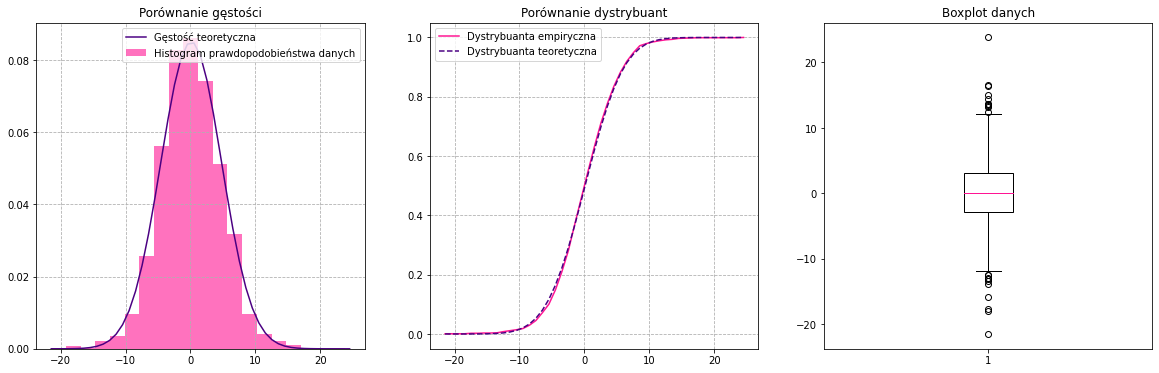

In [72]:
normality(cocoa_close)

Do danych dobieramy odpowiedni rozkład. W naszym przypadku jest to rozkład GEV.

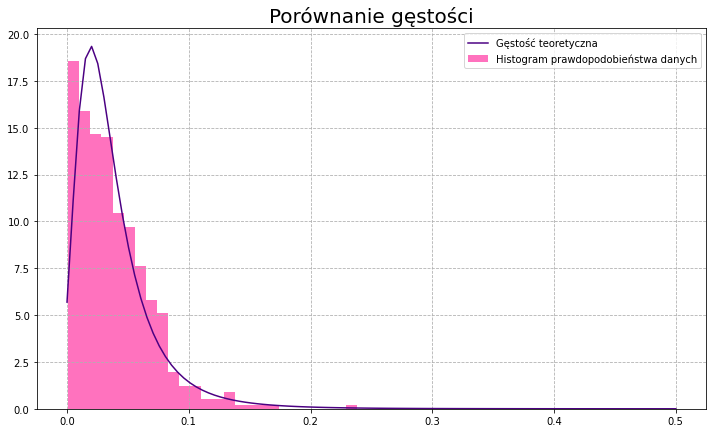

In [73]:
t = np.linspace(0,0.5,100)
plt.hist(L, density=True, bins="auto", label="Histogram prawdopodobieństwa danych", color='deeppink', alpha=0.6)
fit = gev.fit(L)
pdf = gev.pdf(t, *fit)
plt.plot(t, pdf, label="Gęstość teoretyczna", color='indigo')
plt.title("Porównanie gęstości", fontsize=20)
plt.legend()
#plt.savefig("gev_dens")
plt.show()

In [74]:
print("parametry rozkładu: ", fit) #shape, location, scale

parametry rozkładu:  (-0.1915170844835163, 0.022761440773623947, 0.01933471301894278)


In [75]:
mu_c = np.mean(cocoa_close)
sigma_c = np.std(cocoa_close)
stats.norm.ppf(0.95, mu_c, sigma_c)/100

0.07825894287081127

In [76]:
stats.norm.ppf(0.99,mu_c,sigma_c)/100

0.11021798361318876

In [77]:
ksi = fit[0]
mu = fit[1]
sigma = fit[2]

$VaR_{95\%}$

In [78]:
mu - (sigma/ksi)*(1-(-np.log(0.95))**(-ksi)) #tu chyba jest błąd

0.06655797295748683

$VaR_{99\%}$

In [79]:
mu - (sigma/ksi) * (1-(-np.log(0.99))**(-ksi))

0.08188450864727688

## b) metoda historyczna

### zwykła

In [80]:
np.quantile(L, 0.95) #punkt, poniżej którego jest 5% obserwacji

0.08951999999999995

In [81]:
np.quantile(L, 0.99)

0.13597829999999997

### ważona

In [82]:
lamb1 = 0.95
lamb2 = 0.99
n = len(L)

In [83]:
w1 = 1/(1+np.sum([lamb1**(i-1) for i in range(2,n+1)]))

In [84]:
weights = [w1*lamb1**(i-1) for i in range(1,n+1)]

In [85]:
sorted_L = sorted(list(zip(cocoa_close, weights)), key=lambda x: x[0])

In [86]:
sorted_Lprob = [[sorted_L[i][0], sum(sorted_L[j][1] for j in range(0, i+1))] for i in range(0, n)]

In [87]:
#szukamy takiego elementu listy (druga wartość - waga), żeby był on w przybliżeniu równy alpha
diff = [abs(sorted_Lprob[i][1]-lamb1) for i in range(0, n)]
ind = diff.index(min(diff))
print(sorted_Lprob[ind]) #wartość VaR to pierwszy element z listy

[6.497, 0.9522069677065228]


$VaR_{95\%} = 0.06497$

In [88]:
w1_lamb2 = 1/(1+np.sum([lamb2**(i-1) for i in range(2, n+1)]))

In [89]:
weights_lamb2 = [w1_lamb2*lamb2**(i-1) for i in range(1, n+1)]

In [90]:
sortedL_lamb2= sorted(list(zip(cocoa_close, weights_lamb2)), key=lambda x: x[0])

In [91]:
sortedL_prob_lamb2 = [[sortedL_lamb2[i][0], sum(sortedL_lamb2[j][1] for j in range(0, i+1))] for i in range(0, n)]

In [92]:
#szukamy takiego elementu listy (druga wartość - waga), żeby był on w przybliżeniu równy alpha
diff2 = [abs(sortedL_prob_lamb2[i][1]-lamb2) for i in range(0, n)]
ind2 = diff2.index(min(diff2))
print(sortedL_prob_lamb2[ind2]) #wartość VaR to pierwszy element z listy

[13.654, 0.9917786100972099]


$VaR_{99\%} = 0.13654$

### przy użyciu filtrowania szeregiem GARCH

## c) metoda Monte Carlo

In [134]:
#dobieramy model regresji liniowej dla zmiennej kakao opisanej czynnikiem ryzyka
y1 = cocoa_close[0:626]
x1 = pln_usd_close[0:626]
x1 = sm.add_constant(x1)
model1 = sm.GLS(y1, x1).fit()

print(model1.summary())

alpha1 = model1.params[0]
beta1 = model1.params[1]
print(alpha1, beta1)



                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            GLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.463
Date:                Wed, 01 Jun 2022   Prob (F-statistic):              0.117
Time:                        14:10:08   Log-Likelihood:                -1850.1
No. Observations:                 626   AIC:                             3704.
Df Residuals:                     624   BIC:                             3713.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0649      0.186      0.348      0.7

In [136]:
residuals = model1.resid
sigma_resid = np.var(residuals)
mu_resid = np.mean(residuals)

In [126]:
train = pln_usd_close[0:626]
test = pln_usd_close[626:1252]

In [127]:
def func(data, alpha, beta):
    
    return alpha + beta*data

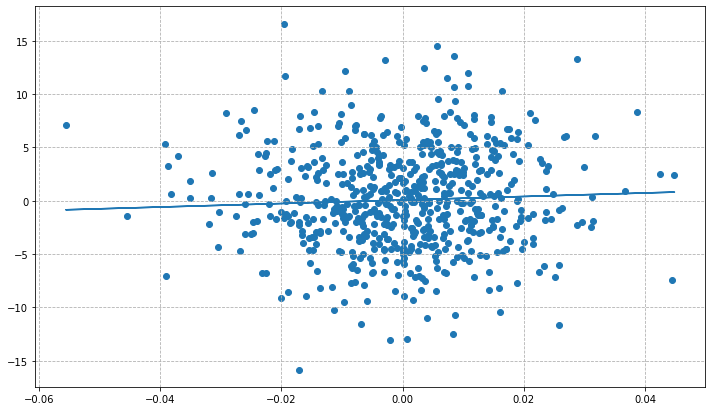

In [128]:
plt.scatter(test, cocoa_close[626:1252])
plt.plot(test, func(test, alpha1, beta1))

In [129]:
N = func(test, alpha1, beta1)

$VaR_{95\%}$

In [130]:
np.quantile(N, 0.95)

0.4248868186689412

$VaR_{99\%}$

# 3. Testowanie wsteczne dla każdego z podpunktów.